# **Loading Dataset from Kaggle to Dataframe**

### **A. Load Python Questions from Stack Overflow Kaggle Datasets**

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download stackoverflow/pythonquestions

 99% 551M/558M [00:19<00:00, 33.6MB/s]
100% 558M/558M [00:19<00:00, 29.8MB/s]


In [ ]:
! unzip pythonquestions.zip

Archive:  pythonquestions.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


### **B. Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import string
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **C. Reading and Displaying Datasets**

In [ ]:
questions = pd.read_csv('Questions.csv', encoding='latin')
answers = pd.read_csv('Answers.csv', encoding='latin')
tags = pd.read_csv('Tags.csv', encoding='latin')

In [ ]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [ ]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [ ]:
tags.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


# **Data Preprocessing**

### **A. Merging The Datasets**

#### **1. 'Questions' Dataset**

In [ ]:
# Rename column names
questions.columns=['Id', 'OwnerUserId',	'CreationDate',	'Score',	'Title', 'Question']

In [ ]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Question
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


#### **2. 'Answers' Dataset**

In [ ]:
# Dropping unecessary columns
answers.drop(columns=['Id', 'OwnerUserId', 'CreationDate'], inplace=True)

# Rename column names
answers.columns=['Id', 'Score', 'Answer']

In [ ]:
# Joining answers grouped by 'Id'
grouped_answers = answers.groupby('Id')['Answer'].apply(lambda answer: ' '.join(answer))
grouped_answers = grouped_answers.to_frame().reset_index()

In [ ]:
grouped_answers.head()

,Id,Answer
0,469,<p>open up a terminal (Applications-&gt;Utilit...
1,502,<p>You can use ImageMagick's convert utility f...
2,535,<p>One possibility is Hudson. It's written in...
3,594,<p>The canonical way is to use the built-in cu...
4,683,"<p>No, you were not dreaming. Python has a pr..."


#### **3. 'Tags' Dataset**

In [ ]:
# Changing the data type of 'Tag' column to string
tags['Tag']= tags['Tag'].astype(str)

# Joining tags grouped by 'Id'
grouped_tags = tags.groupby('Id')['Tag'].apply(lambda tag: ' '.join(tag))
grouped_tags = grouped_tags.to_frame().reset_index()

In [ ]:
grouped_tags.head()

,Id,Tag
0,469,python osx fonts photoshop
1,502,python windows image pdf
2,535,python continuous-integration extreme-programming
3,594,python sql database oracle cx-oracle
4,683,python arrays iteration


#### **4. Merging to a Single Dataset**

In [ ]:
# Merging 'Questions' dataframe with 'Answers' dataframe, then with 'Tags' dataframe 
df = questions.merge(grouped_answers, how='left', on='Id')
df = df.merge(grouped_tags, how='left', on='Id')

In [ ]:
df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Question,Answer,Tag
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,<p>open up a terminal (Applications-&gt;Utilit...,python osx fonts photoshop
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,<p>You can use ImageMagick's convert utility f...,python windows image pdf
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,<p>One possibility is Hudson. It's written in...,python continuous-integration extreme-programming
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,<p>The canonical way is to use the built-in cu...,python sql database oracle cx-oracle
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,"<p>No, you were not dreaming. Python has a pr...",python arrays iteration


In [ ]:
df.drop(columns=['Id', 'OwnerUserId', 'CreationDate'], inplace=True)

In [ ]:
df.head()

,Score,Title,Question,Answer,Tag
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,<p>open up a terminal (Applications-&gt;Utilit...,python osx fonts photoshop
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,<p>You can use ImageMagick's convert utility f...,python windows image pdf
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,<p>One possibility is Hudson. It's written in...,python continuous-integration extreme-programming
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,<p>The canonical way is to use the built-in cu...,python sql database oracle cx-oracle
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,"<p>No, you were not dreaming. Python has a pr...",python arrays iteration


### **B. Filtering Dataset Based on 'Score' Column and Most Frequently Used Tags**

In [ ]:
# Renaming column names
df.columns = ['score', 'title', 'question', 'answer', 'tag']

In [ ]:
df.head()

,score,title,question,answer,tag
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,<p>open up a terminal (Applications-&gt;Utilit...,python osx fonts photoshop
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,<p>You can use ImageMagick's convert utility f...,python windows image pdf
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,<p>One possibility is Hudson. It's written in...,python continuous-integration extreme-programming
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,<p>The canonical way is to use the built-in cu...,python sql database oracle cx-oracle
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,"<p>No, you were not dreaming. Python has a pr...",python arrays iteration


In [ ]:
# Creating 'tag_count' column
temp_df = df.groupby('tag')['tag'].count()
temp_df = temp_df.to_frame()
temp_df.columns = ['tag_count']
temp_df = temp_df.reset_index()

In [ ]:
temp_df.sort_values('tag_count', ascending=False).head()

,tag,tag_count
12278,python,43290
50516,python django,11910
154008,python pandas,8603
189825,python regex,6192
169519,python python-2.7,6002


In [ ]:
# Merging created column to the existing dataframe
df= pd.merge(df, temp_df, how='left', on='tag')

In [ ]:
df.head()

,score,title,question,answer,tag,tag_count
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,<p>open up a terminal (Applications-&gt;Utilit...,python osx fonts photoshop,1
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,<p>You can use ImageMagick's convert utility f...,python windows image pdf,1
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,<p>One possibility is Hudson. It's written in...,python continuous-integration extreme-programming,1
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,<p>The canonical way is to use the built-in cu...,python sql database oracle cx-oracle,2
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,"<p>No, you were not dreaming. Python has a pr...",python arrays iteration,4


In [ ]:
df.head(10)

,score,title,question,answer,tag,tag_count
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,<p>open up a terminal (Applications-&gt;Utilit...,python osx fonts photoshop,1
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,<p>You can use ImageMagick's convert utility f...,python windows image pdf,1
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,<p>One possibility is Hudson. It's written in...,python continuous-integration extreme-programming,1
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,<p>The canonical way is to use the built-in cu...,python sql database oracle cx-oracle,2
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,"<p>No, you were not dreaming. Python has a pr...",python arrays iteration,4
5,30,Class views in Django,"<p><a href=""http://www.djangoproject.com/"">Dja...",<p>Sounds to me like you're trying to combine ...,python django views oop,1
6,20,Python and MySQL,<p>I can get Python to work with Postgresql bu...,"<p>I don't have any experience with <a href=""h...",python mysql postgresql bpgsql,1
7,256,How do I use Python's itertools.groupby()?,<p>I haven't been able to find an understandab...,<p>Can you show us your code?</p>\n\n<p>The ex...,python iteration,91
8,364,Adding a Method to an Existing Object Instance,<p>I've read that it is possible to add a meth...,<p>In Python monkey patching generally works b...,python oop methods monkeypatching,2
9,251,How do you express binary literals in Python?,<p>How do you express an integer as a binary n...,"<p>As far as I can tell Python, up through 2.5...",python syntax binary integer literals,1


In [ ]:
df = df[(df['tag_count'] >= 1000) & (df['score'] > 3)]

In [ ]:
df.shape

(12044, 6)

In [ ]:
df.sort_values('tag_count', ascending=False)

,score,title,question,answer,tag,tag_count
11,12,How do I make a menu that does not require the...,<p>I've got a menu in Python. That part was ea...,<p><strong>On Linux:</strong></p>\n\n<ul>\n<li...,python,43290
100951,16,"Python: What does ""foo() for i in range(bar)"" ...",<p>What exactly does the following statement m...,"<p>The way you posted it, it's a <a href=""http...",python,43290
101892,18,Pythonic way to access arbitrary element from ...,"<p>I have a dictionary, full of items. I want ...","<p>Similar to your second solution, but slight...",python,43290
101783,4,Average network statistics in Python,<p>I'm new to python and I need to calculate t...,<p>Take your main() and get_network_bytes() an...,python,43290
101745,20,What is the difference between Python vs Jytho...,<p>I am quite new in Python programming. While...,<p>Jython and IronPython are different python ...,python,43290
...,...,...,...,...,...,...
135434,10,How can i extract only text in scrapy selector...,<p>I have this code</p>\n\n<pre><code> site ...,<p>I haven't got a scrapy instance running so ...,python scrapy,1000
135422,5,How to enable cookiemiddleware in scrapy in py...,"<p>IN their documentation here <a href=""http:/...",<p><strong>update</strong> it would appear coo...,python scrapy,1000
574146,4,Scrapy from list to extract key or value,<p>i'm new to python and have some trouble wra...,<p><strong>Target based on ranks</strong></p>\...,python scrapy,1000
299386,13,When and how should use multiple spiders in on...,"<p>I am using <code>Scrapy</code>, it is great...",<p>I don't know if it will answer to your firs...,python scrapy,1000


### **C. Cleaning The Data**

In [ ]:
df.isnull().sum()

score         0
title         0
question      0
answer       43
tag           0
tag_count     0
dtype: int64

In [ ]:
# Dropping 'answer' column since it can't be imputed (because this column values is neither categorical nor continuous in nature)
df.drop(columns=['answer'], inplace=True)

In [ ]:
# Defining a function to remove punctuation
def punctuation_remover(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Changing the data type of 'title' column to string
df['title'] = df['title'].astype(str)

# Applying 'punctuation_remover' function on 'title' column
df['title'] = df['title'].apply(punctuation_remover)

# Changing text into lowercase
df['title'] = df['title'].str.lower()

# Splitting the text into words
df['title'] = df['title'].str.split()

In [ ]:
# Changing the data type of 'question' column to string
df['question'] = df['question'].astype(str)

# Removing HTML tags on 'question' column values
df['question'] = df['question'].apply(lambda question: re.sub('<[^<]+?>', '', question))

# Applying 'punctuation_remover' function on 'question' column
df['question'] = df['question'].apply(punctuation_remover)

# Changing text into lowercase
df['question'] = df['question'].str.lower()

# Splitting the text into words
df['question'] = df['question'].str.split()

In [ ]:
df['title'].head()

11    [how, do, i, make, a, menu, that, does, not, r...
12    [how, to, check, what, os, am, i, running, on,...
16    [calling, a, function, of, a, module, from, a,...
29    [how, do, i, treat, an, integer, as, an, array...
58    [how, do, i, download, a, file, over, http, us...
Name: title, dtype: object

In [ ]:
df['question'].head()

11    [ive, got, a, menu, in, python, that, part, wa...
12    [what, do, i, need, to, look, at, to, see, if,...
16    [what, is, the, best, way, to, go, about, call...
29    [im, trying, to, decode, the, result, of, the,...
58    [i, have, a, small, utility, that, i, use, to,...
Name: question, dtype: object

### **D. Lemmatization**

In [ ]:
lematizer = WordNetLemmatizer()

# Defining lemmatizer function
def word_lemmatizer(text):
    lemma_text = [lematizer.lemmatize(word) for word in text]
    return lemma_text

In [ ]:
# Applying lemmatizer function to 'title' and 'answer' columns
df['title'] = df['title'].apply(lambda title: word_lemmatizer(title))
df['question'] = df['question'].apply(lambda question: word_lemmatizer(question))

### **E. Removing Stopword**

In [ ]:
df['title'] = df['title'].apply(lambda title: [word for word in title if word not in stopwords.words('english')])
df['question'] = df['question'].apply(lambda question: [word for word in question if word not in stopwords.words('english')])

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df['title'].head()

11    [make, menu, doe, require, user, press, enter,...
12                             [check, running, python]
16    [calling, function, module, string, function, ...
29                [treat, integer, array, byte, python]
58                [download, file, http, using, python]
Name: title, dtype: object

In [ ]:
df['question'].head()

11    [ive, got, menu, python, part, wa, easy, im, u...
12             [need, look, see, im, window, unix, etc]
16    [best, way, go, calling, function, given, stri...
29    [im, trying, decode, result, python, oswait, f...
58    [small, utility, use, download, mp3, website, ...
Name: question, dtype: object

In [ ]:
df.drop(columns=['score', 'tag_count'], inplace=True)

In [ ]:
df.title[12]

['check', 'running', 'python']

### **F. TF-IDF Vectorization**

In [ ]:
'''
TF-IDF equation:
TF = (# of times of specific word in a doc) / (# of words in doc)
IDF = log((# of docs) / (# of docs that contains specific word))
TF-IDF = TF * IDF
'''

vectorizer = TfidfVectorizer()

# Changing the data type of 'title' and 'question' columns to string
df['title'] = df['title'].astype(str)
df['question'] = df['question'].astype(str)

X1 = vectorizer.fit_transform(df['title'].str.lower())
X2 = vectorizer.fit_transform(df['question'].str.lower())

In [ ]:
print(X2)

  (0, 86147)	0.08861650904205061
  (0, 23366)	0.16915899566211257
  (0, 50509)	0.5074769869863376
  (0, 51622)	0.03483148450794355
  (0, 83708)	0.0497577383425753
  (0, 41894)	0.09436248609254481
  (0, 97321)	0.04180020885397638
  (0, 34280)	0.08967875941316417
  (0, 78759)	0.16915899566211257
  (0, 73735)	0.16915899566211257
  (0, 16560)	0.20604154666512225
  (0, 19842)	0.16767812720573932
  (0, 38550)	0.15677718224080936
  (0, 78042)	0.12349866546018279
  (0, 70305)	0.18666309536615075
  (0, 87254)	0.08682272825649469
  (0, 46098)	0.043993920931248466
  (0, 36463)	0.07328998300264931
  (0, 49836)	0.16915899566211257
  (0, 93267)	0.10986518435937952
  (0, 46040)	0.11015818649661721
  (0, 14938)	0.11650327382170565
  (0, 71340)	0.07025472122136338
  (0, 96424)	0.03775270050310469
  (0, 54497)	0.11338556302523975
  :	:
  (12042, 41754)	0.026228241817810805
  (12042, 48765)	0.021455120697642733
  (12043, 61904)	0.19794577121851745
  (12043, 30967)	0.19794577121851745
  (12043, 67294)	0.1

In [ ]:
label_encoder = LabelEncoder() 

df['tag'] = label_encoder.fit_transform(df['tag'])
y = df['tag'].values

# **Splitting The Dataset to Train and Test Sets**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

In [ ]:
accuracy = []

for i in range(1, 40):
    KNN = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)
    prediction = KNN.predict(x_test)
    accuracy.append(metrics.accuracy_score(y_test, prediction))

Maximum Accuracy: 0.6314333148865523 at K = 29


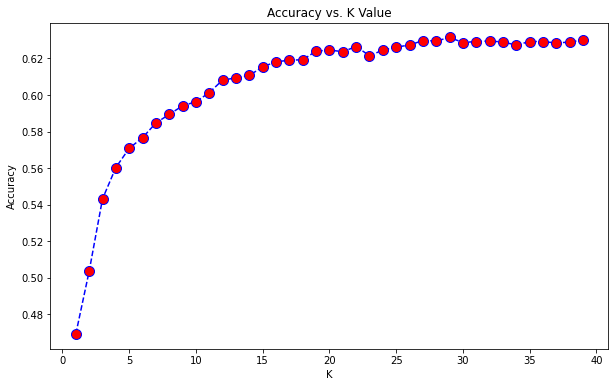

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), accuracy, color = 'blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum Accuracy:", max(accuracy), "at K =", accuracy.index(max(accuracy))+1)